In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import tensorflow as tf
CONFIG = tf.ConfigProto(device_count = {'GPU': 1}, log_device_placement=False, allow_soft_placement=False)
CONFIG.gpu_options.allow_growth = True # Prevents tf from grabbing all gpu memory.
sess = tf.Session(config=CONFIG)
from keras import backend as K
K.set_session(sess)


import h5py
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from collections import defaultdict
import pandas as pd
import matplotlib as mpl
import supp_func
import importlib
importlib.reload(supp_func)
from sklearn import metrics
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from numpy import interp
import pickle as pkl

/home/yadongl1/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Preparing data

# Training

In [2]:
def sigmoid(x):
     return 1 / (1 + np.exp(-x))
def hard_sigmoid(x):
    return np.minimum(np.maximum(x, np.zeros_like(x)), np.ones_like(x)) 

def train_model(data, epoch):
    hp={'p':data['X'].shape[1],
        'q':data['Y'].shape[1],
        'K': 100,
        'zeta': 1.1,
        'gamma': -0.1,
        'gamma_zeta_logratio': np.log(0.1/1.1),
        'beta_p': 0.666
       }

    K = hp['K']
    p = hp['p']
    q = hp['q']
    zeta = hp['zeta']
    gamma = hp['gamma']
    gamma_zeta_logratio = hp['gamma_zeta_logratio']
    beta_p = hp['beta_p']

    tf.reset_default_graph()

    mu_beta_0 = tf.get_variable("mu_beta_0", shape=[p,q], initializer=tf.contrib.layers.xavier_initializer()) 
    mu_beta_1 = tf.get_variable("mu_beta_1", shape=[p,q], initializer=tf.contrib.layers.xavier_initializer())


    alpha = tf.get_variable("alpha", shape=[p,q], initializer=tf.contrib.layers.xavier_initializer())
    alpha_rep  = tf.stack([alpha]*K)
    bias = tf.get_variable("bias", shape=[1,q], initializer=tf.contrib.layers.xavier_initializer()) 

    x = tf.placeholder(tf.float32,[data['X'].shape[0],data['X'].shape[1]], name='data_x')
    y = tf.placeholder(tf.float32,[data['Y'].shape[0],data['Y'].shape[1]], name='data_y')

    ###########################  define model flow       
    u = tf.random_uniform(shape=(K, p,q), minval=0, maxval=1,dtype=tf.float32)
    s0 = tf.sigmoid( (tf.math.log(u) - tf.math.log(1 - u) + alpha_rep ) / beta_p )
    s = s0 * (zeta - gamma) + gamma # stretch s
    mask = tf.clip_by_value(s,0,1) # hard_sigmoid(s) shape=(K,p)
    ###########################
    mu_beta = tf.where(tf.random_uniform([p]) - 0.5 < 0, mu_beta_0, mu_beta_1)
    mu_beta_rep = tf.stack([mu_beta]*K)

    noise = tf.random_normal(shape=(K, p,q), mean=0, stddev=1,dtype=tf.float32)
    beta = tf.math.add(noise, mu_beta_rep)

    masked_weights = tf.multiply(mask, beta)  # shape(K,p)
    activation = tf.reduce_mean(tf.tensordot(x, masked_weights, axes=[[1],[1]] ), axis=1) + bias #?tf.add #shape=(None,100)
    y_pred = tf.exp(activation)



    class compute_loss:
        def __init__(self,  p=None, q=None,K=None):
            self.K  = K
            self.p  = p
            self.q  = q
        def NegDM_loglike(self,labels, y_pred):
            delta = y_pred # the first ouput corresponds to delta; 2nd corresponds to L0 penalty
            negloglike = -(tf.lgamma(labels+delta) - tf.lgamma(delta)) 
            negloglike = tf.reduce_sum(negloglike,axis=-1) \
            - ( tf.lgamma(tf.reduce_sum(delta,axis=-1)) - tf.lgamma(tf.reduce_sum(labels,axis=-1)+tf.reduce_sum(delta,axis=-1)) ) 
            negloglike = tf.reduce_sum(negloglike)
            return negloglike
        def KL_welling(self, beta,mu_beta, alpha, noise, beta_p,gamma_zeta_logratio):
            log_qz = tf.reduce_sum( tf.math.log( tf.sigmoid(alpha - beta_p * gamma_zeta_logratio) ) ) 
            qz =   tf.reduce_sum( tf.sigmoid(alpha - beta_p * gamma_zeta_logratio)  )
            log_pz = tf.reduce_sum( tf.math.log(np.zeros([self.K, self.p, self.q], dtype=np.float32) + 0.5) ) / self.K
            KLD =  log_qz - log_pz + tf.reduce_sum(-0.5*tf.square(mu_beta)+tf.reduce_mean(tf.math.log(tf.square(beta)) ,axis=0)) # - log_pbeta + log_qbeta
            return qz, KLD 
        def KL_MC(self, beta,mu_beta, alpha, noise, beta_p,gamma_zeta_logratio):
            qz =    tf.sigmoid(alpha - beta_p * gamma_zeta_logratio)
            neg_entropy_q = tf.reduce_mean(tf.log(0.5/np.sqrt(2*np.pi)*tf.math.exp(-0.5*tf.square(beta-mu_beta_0)) \
                                                +0.5/np.sqrt(2*np.pi)*tf.math.exp(-0.5*tf.square(beta-mu_beta_1))) ,axis=0)
            KLD_tau_2 = tf.reduce_sum(qz*tf.log(qz/0.5) + (1-qz)*tf.log((1-qz)/0.5)) + \
                                    tf.reduce_sum(qz*(neg_entropy_q + \
                                    0.125*tf.square(mu_beta_0) + 0.125*tf.square(mu_beta_1) +\
                                    np.log(np.sqrt(np.pi)) + 2*np.log(2)-\
                                    tf.reduce_mean(tf.math.log(1*tf.square(beta) +1e-10) ,axis=0)))
            return KLD_tau_2, neg_entropy_q, qz #log_qz, log_qbeta, log_pz, log_pbeta, KLD



    ##################
    compute = compute_loss(p=hp['p'], q=hp['q'],K=hp['K'])
    Neglikelihood = compute.NegDM_loglike(y, y_pred)
    KLD_tau_2, neg_entropy_q, qz = compute.KL_MC(beta,mu_beta, alpha, noise, beta_p,gamma_zeta_logratio)
    loss = Neglikelihood + 1*KLD_tau_2
    ##################

    lr=tf.placeholder(tf.float32, name='learning_rate')
    train_op1 = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss,var_list=[mu_beta_1, mu_beta_0, alpha, bias])


    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)
    for i in range(epoch):
        _,cost,vKL,vNeglikelihood, valpha,vmu_beta, vneg_entropy_q, vqz =sess.run([train_op1,loss,KLD_tau_2,Neglikelihood, alpha,mu_beta,  neg_entropy_q, qz],\
                                         feed_dict={x:data['X'],y:data['Y'],lr:0.001} ) #
        if i % 4000==0:
            pred = sigmoid(valpha)*(zeta - gamma) + gamma
            print('epoch', i)
    beta = 2/3
    zeta= 1.1
    gamma = -0.1
    s=sigmoid(valpha)*(zeta - gamma) + gamma
    s= hard_sigmoid(s)
    threshold = search_threshold(s, 0.1)
    s[s<threshold]=0
    s[s>threshold]=1
    
    pred = sigmoid(valpha)*(zeta - gamma) + gamma
    pred = hard_sigmoid(pred)
    print('implied FDR' ,compute_implied_fdr(threshold, pred)  )  
    return s, valpha, pred

# compute statistics

In [3]:
def compute_statistics(data, s, pred, VI = 'False'):
    """
    Inputs:
        data: dictionary containing xi_true
        s: binary indicator of non-zero beta values
        pred: predicted beta value
    
    Returns:
        [precision, recall, MCC, AUC, F1, ACC]
    """
    p= data['X'].shape[1]
    q=data['Y'].shape[1]
    y = data['xi_true'].reshape(1,p*q)[0]
    if VI == True:
        y = data['xi_true'].T.reshape(1,p*q)[0]  # .T needed when compute VI statistics
    pred_bin = s.reshape(1,p*q)[0]
    pred = pred.reshape(1,p*q)[0]
    
    fpr, tpr, _ = roc_curve(y,pred)
    roc_auc = auc(fpr, tpr)
    
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, pred_bin).ravel()

    P=25 # (p+q)*inclusion
    N=2500-25#p*q - P
    FDR = fp/(fp+tp)
    ACC = (tp+tn)/(P+N)
    MCC = ((tp*tn) - (fp*fn)) / np.sqrt( (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) )
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    AUC = metrics.roc_auc_score(y, pred)
    return [precision, recall, MCC, AUC, F1, ACC], [fpr, tpr, roc_auc]


def compute_implied_fdr(threshold, s):
    """
    Inputs:
        s: predicted probability
        threshold: level greater than threshold are selected
    
    Returns:
        fdr corresponding to the threshold
    """        
    indicator = np.asarray( [s>threshold] )
    return np.sum( (1-s)*indicator ) / np.sum(indicator)


def search_threshold(s, fdr):
    """
    Inputs:
        s: predicted probability
        fdr: controlled false discovery rate level
    
    Returns:
        largest threshold such that the fdr is less than the controlled level: fdr
    """    
    for threshold in np.linspace(0,1,101):
        if compute_implied_fdr(threshold, s) < fdr:
            break
    return threshold
        

def plot_roc(fpr, tpr, roc_auc, color,linestyle, method_name):
    mean_auc = np.mean(roc_auc)
    std_auc = np.std(roc_auc)
    mean_tpr = np.mean(tpr,axis=0)
    std_tpr = np.std(tpr,axis=0)
    plt.plot(fpr, mean_tpr, color=color,linestyle=linestyle,
             label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (method_name, mean_auc, std_auc),
             lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=.8)
    
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(fpr, tprs_lower, tprs_upper, color=color, alpha=.2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Average False Positive Rate')
    plt.ylabel('Average True Positive Rate')
    plt.legend(loc="lower right")

# Running repeated experiments: 50 times

Note that reading from h5 file created by R program, we need to swap the axis using np.transpose. Note here we have two cases: 1) $\psi = 0.01$ and 2) $\psi = 0.1$. And we need to change their name in when we read the data. (rep_50_001.h5 and rep_50_01.h5)

First a look into the data:

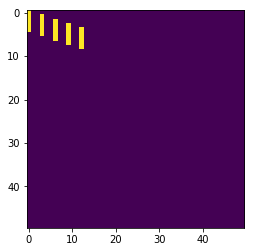

In [4]:
repetition = 50
data_dir = "/extra/yadongl10/DMVS/data/rep_50_data/"
p=50
q=50
pred_matrix = np.zeros([repetition, p, q])
statistics_matrix = np.zeros([repetition, 6])

with h5py.File(data_dir+'rep_50_001.h5', 'r') as f:
    cov_duncan_01 = np.transpose(np.asarray(f['cov_duncan_001']), axes=[2,1,0])
    response_duncan_01 = np.transpose(np.asarray(f['response_duncan_001']), axes=[2,1,0])
    truebeta_duncan_01 = np.transpose(np.asarray(f['truebeta_duncan_001']), axes=[2,1,0])
ind = 20
XX = cov_duncan_01[ind,:,1:]
YY = response_duncan_01[ind,:,:]
truebeta = truebeta_duncan_01[ind,:,:]
data = {}
data['X'] = XX
data['Y'] = YY
truebeta = truebeta_duncan_01[ind,:,:]
xi_true = np.zeros_like(truebeta)
xi_true[truebeta!=.0]=1
data['xi_true'] = xi_true
plt.imshow(xi_true)

We start to train 50 repeated experiments

In [155]:
for ind in range(repetition):
    print('start repetition {}'.format(ind))
    ### prepare data
    XX = cov_duncan_01[ind,:,1:]
    YY = response_duncan_01[ind,:,:]
    truebeta = truebeta_duncan_01[ind,:,:]
    data = {}
    data['X'] = XX
    data['Y'] = YY
    data['truebeta'] = truebeta
    xi_true = np.zeros_like(truebeta)
    xi_true[truebeta!=.0]=1
    data['xi_true'] = xi_true
    ### train model 
    s, valpha, pred = train_model(data, epoch = 10000)
    print('finish training') 
    print('PPI',np.mean(pred), np.max(pred) )
    pred_matrix[ind,:,:] = pred
    ### compute statistics
    statistics_matrix[ind,:],[fpr, tpr, roc_auc]  = compute_statistics(data, s, pred)
    print(statistics_matrix[ind,:])

start repetition 0
epoch 0
epoch 4000
epoch 8000
implied FDR 0.09944656762209805
finish training
PPI 0.02244169 1.0
[1.         0.44       0.66145681 0.99972525 0.61111111 0.9944    ]
start repetition 1
epoch 0
epoch 4000
epoch 8000
implied FDR 0.09889970223108928
finish training
PPI 0.024254816 1.0
[1.         0.48       0.69100793 0.97132121 0.64864865 0.9948    ]
start repetition 2
epoch 0
epoch 4000
epoch 8000
implied FDR 0.09572807285520765
finish training
PPI 0.023610108 0.9753393
[1.         0.36       0.59806996 0.99898182 0.52941176 0.9936    ]
start repetition 3
epoch 0
epoch 4000
epoch 8000
implied FDR 0.09680642579731188
finish training
PPI 0.023987118 1.0
[0.89473684 0.68       0.77814393 0.99730101 0.77272727 0.996     ]
start repetition 4
epoch 0
epoch 4000
epoch 8000
implied FDR 0.09592432975769043
finish training
PPI 0.022600975 1.0
[1.         0.4        0.63054767 0.99857778 0.57142857 0.994     ]
start repetition 5
epoch 0
epoch 4000
epoch 8000
implied FDR 0.0999063

epoch 0
epoch 4000
epoch 8000
implied FDR 0.09189055114984512
finish training
PPI 0.02548629 0.9800464
[0.875      0.28       0.49257173 0.99557172 0.42424242 0.9924    ]
start repetition 45
epoch 0
epoch 4000
epoch 8000
implied FDR 0.09123323559761047
finish training
PPI 0.023197513 1.0
[0.8        0.32       0.5031643  0.99736566 0.45714286 0.9924    ]
start repetition 46
epoch 0
epoch 4000
epoch 8000
implied FDR 0.09092613723542955
finish training
PPI 0.022111395 0.96925175
[1.         0.36       0.59806996 0.99964444 0.52941176 0.9936    ]
start repetition 47
epoch 0
epoch 4000
epoch 8000
implied FDR 0.09380195357582786
finish training
PPI 0.02236539 0.9923178
[1.         0.44       0.66145681 0.99898182 0.61111111 0.9944    ]
start repetition 48
epoch 0
epoch 4000
epoch 8000
implied FDR 0.0886605978012085
finish training
PPI 0.022805478 0.971501
[1.         0.36       0.59806996 0.99975758 0.52941176 0.9936    ]
start repetition 49
epoch 0
epoch 4000
epoch 8000
implied FDR 0.08988

In [157]:
# dump the result matrix to pkl file
import pickle as pkl
with open('/extra/yadongl10/DMVS/results_rep_50/pred_matrix_001.pkl','wb') as file:
    pkl.dump(pred_matrix, file)
with open('/extra/yadongl10/DMVS/results_rep_50/statistics_matrix_001.pkl','wb') as file:
    pkl.dump(statistics_matrix, file)

# Load VI prediction

In [40]:
def produce_statistics_matrix(repetition,data, pm, VI=False):  
    """
    Input: 
    repetition
    data
    pm: prediction matrix, shape=(repetition, 2500) or (repetition, 50, 50)
    """
    statistics_matrix = np.zeros([repetition, 6]) 
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for ind in range(repetition):
        pred = pm[ind,:]
        threshold = search_threshold(pred, 0.1) # search threshold for every repeated exp
        if threshold == 1:
            continue
#         print(threshold)
        s = np.zeros_like(pred)
        s[pred<threshold]=0
        s[pred>threshold]=1
        statistics_matrix[ind,:],[fpr, tpr, roc_auc]  = compute_statistics(data, s, pred, VI=VI)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)
    print('mean of stats matrix controlling FDR=0.1', np.mean(statistics_matrix,axis=0))
    print('sd of stats matrix controlling FDR=0.1',np.std(statistics_matrix,axis=0))
    return [s, statistics_matrix], [mean_fpr, tprs, aucs]


mean of stats matrix controlling FDR=0.1 [0.75203401 0.4432     0.56768779 0.90772752 0.54669853 0.99284   ]
sd of stats matrix controlling FDR=0.1 [0.11012324 0.10668533 0.08152689 0.04894292 0.09307651 0.00108296]


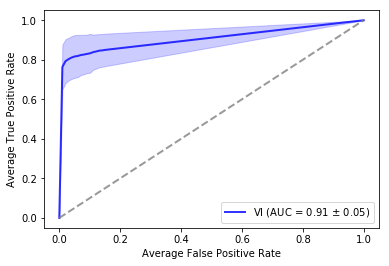

In [48]:
repetition = 50
with open('/extra/yadongl10/DMVS/results_rep_50/pred_matrix_01.pkl','rb') as file:
    pm = pkl.load(file)
[s, statistics_matrix], [mean_fpr, tprs_vi, aucs_vi] = produce_statistics_matrix(repetition,data,pm, VI=True)
plot_roc(mean_fpr, tprs_vi, aucs_vi, color='b', linestyle='-', method_name='VI')


# A look at Chen and Li's results

## results for chenli $\psi = 0.1$

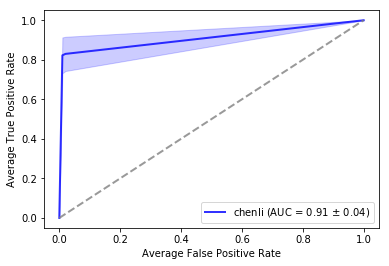

In [29]:
chenli_results_dir = '/extra/yadongl10/DMVS/results_rep_50/chenli_results_001/rep_50_results/'
repetition = 50
p= data['X'].shape[1]
q=data['Y'].shape[1]
P=25
N = 2500 - 25
threshold = .0
statistics_matrix_cl = np.zeros([repetition,6])
tprs_cl = []
aucs_cl = []
mean_fpr = np.linspace(0, 1, 100)

for ind in range(repetition):
    mean_beta_cl = pd.read_csv(chenli_results_dir+'rep_50_resultsest_chenli_001_id_{}.txt'.format(ind+1), sep='\t')
    mean_beta_cl = np.abs(mean_beta_cl.iloc[:, 2:].values.reshape(2500))
    mean_beta_cl_binary = np.zeros_like(mean_beta_cl)
    mean_beta_cl_binary[mean_beta_cl<=threshold] = 0
    mean_beta_cl_binary[mean_beta_cl>threshold] = 1
#     print(mean_beta_cl_binary.reshape(50,50))
    statistics_matrix_cl[ind,:],[fpr, tpr, roc_auc] = compute_statistics(data, mean_beta_cl_binary, mean_beta_cl)
    tprs_cl.append(interp(mean_fpr, fpr, tpr))
    tprs_cl[-1][0] = 0.0
    aucs_cl.append(roc_auc)
    
    
plot_roc(mean_fpr, tprs_cl, aucs_cl, color='b', linestyle='-', method_name='chenli')    

[0.59957866 0.8096     0.69233858 0.91287257 0.68718012 0.992624  ]
[0.06575323 0.09141028 0.06984566 0.04420362 0.06835206 0.00168411]


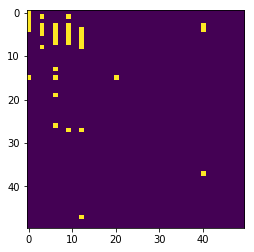

In [400]:
plt.imshow(mean_beta_cl_binary.reshape(50,50))
# [precision, recall, MCC, AUC, F1, ACC]
print( np.mean(statistics_matrix_cl,axis=0) )
print(np.std(statistics_matrix_cl,axis=0))

##  results for chenli $\psi = 0.1$

In [17]:
# [precision, recall, MCC, AUC, F1, ACC]    
print(np.mean(statistics_matrix_cl,axis=0))
np.std(statistics_matrix_cl,axis=0)

[0.33015945 0.732      0.48387004 0.86302885 0.45418665 0.982136  ]


array([0.0725012 , 0.13605881, 0.09922528, 0.0694862 , 0.0936796 ,
       0.00410472])

est_beta_cl_01
(187, 50, 50)


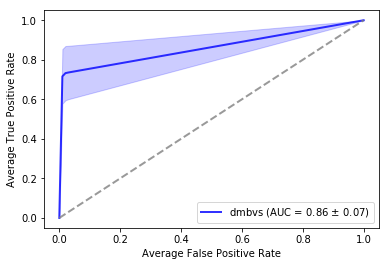

In [216]:
results_dir = '/extra/yadongl10/DMVS/results_rep_50/'
with h5py.File(results_dir+'est_beta_cl_01_200iter.h5', 'r') as f:
    for key in f.keys():
        print(key)
    est_beta_cl_01 = np.transpose(np.asarray(f['est_beta_cl_01']))[:,:,1:]
    est_beta_cl_01 = np.abs(est_beta_cl_01)
    print(est_beta_cl_01.shape)

thresh_cl = 0.
est_beta_cl_01_bin = np.zeros_like(est_beta_cl_01)
est_beta_cl_01_bin[est_beta_cl_01<=thresh_cl] = 0
est_beta_cl_01_bin[est_beta_cl_01>thresh_cl] = 1
# plt.imshow( est_beta_cl_01_bin[1,:,:] )

tprs_cl = []
aucs_cl = []
statistics_matrix_cl = np.zeros([50,6])
mean_fpr = np.linspace(0, 1, 100)
for i in range(50):
    statistics_matrix_cl[i,:], [fpr, tpr, roc_auc] = compute_statistics(data, est_beta_cl_01_bin[i,:], est_beta_cl_01[i,:])
    tprs_cl.append(interp(mean_fpr, fpr, tpr))
    tprs_cl[-1][0] = 0.0
    aucs_cl.append(roc_auc)
    
plot_roc(mean_fpr, tprs_cl, aucs_cl, color='b', linestyle='-', method_name='dmbvs')

# A look at Duncan's results

## results for Duncan $\psi = 0.1$

In [45]:
results_dir = '/extra/yadongl10/DMVS/results_rep_50/'
with h5py.File(results_dir+'est_beta_duncan_001.h5', 'r') as f:
    for key in f.keys():
        print(key)
    est_beta_duncan_01 = np.transpose(np.asarray(f['est_beta_duncan_001']), axes=[1,0])
    print(est_beta_duncan_01.shape)
search_threshold(est_beta_duncan_01[1,:], fdr=0.10)

est_beta_duncan_001
(50, 2500)


0.68

mean of stats matrix controlling FDR=0.1 [0.99567308 0.4816     0.6858336  0.99385147 0.641938   0.994792  ]
sd of stats matrix controlling FDR=0.1 [0.01720724 0.10306037 0.0811221  0.01253379 0.10275686 0.00102603]


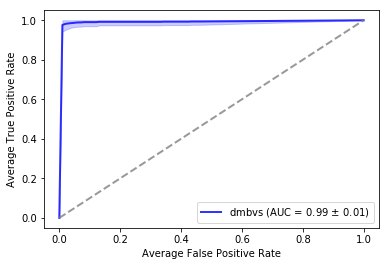

In [46]:
repetition=50
[_, statistics_matrix_duncan], [mean_fpr, tprs_duncan, aucs_duncan] = produce_statistics_matrix(repetition,
                                                                                                data,
                                                                                                est_beta_duncan_01,
                                                                                               VI='False')
plot_roc(mean_fpr, tprs_duncan, aucs_duncan, color='b', linestyle='-', method_name='dmbvs')

In [249]:
statistics_matrix_duncan = np.delete(statistics_matrix_duncan, -4, axis=0)
print( np.mean(statistics_matrix_duncan,axis=0) )
print( np.std(statistics_matrix_duncan,axis=0) )

[0.98284239 0.28833333 0.51031194 0.93452946 0.42573216 0.9928    ]
[0.04486044 0.13927391 0.13688299 0.03399444 0.16930174 0.00131909]


## results for chenli $\psi = 0.1$

FDR = 0.985497692814766


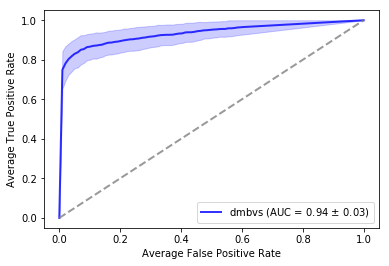

In [240]:

thresh_duncan = search_threshold(s, fdr=0.05)

est_beta_duncan_01_binary = np.zeros_like(est_beta_duncan_01)
est_beta_duncan_01_binary[est_beta_duncan_01<=thresh_duncan] = 0
est_beta_duncan_01_binary[est_beta_duncan_01>thresh_duncan] = 1
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(data['xi_true'].reshape(1,p*q)[0], est_beta_duncan_01_binary[0,:]).ravel()
P= 25
N=50*50 - P
FDR = fp/(fp+tp)
print('FDR =',FDR)

statistics_matrix_duncan = np.zeros([50,6])

tprs_duncan = []
aucs_duncan = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(repetition):
    
    
    statistics_matrix_duncan[i,:], [fpr, tpr, roc_auc] = compute_statistics(data, est_beta_duncan_01_binary[i,:], est_beta_duncan_01[i,:])
    tprs_duncan.append(interp(mean_fpr, fpr, tpr))
    tprs_duncan[-1][0] = 0.0
    aucs_duncan.append(roc_auc)
    
plot_roc(mean_fpr, tprs_duncan, aucs_duncan, color='b', linestyle='-', method_name='dmbvs')

In [163]:
print( np.mean(statistics_matrix_duncan,axis=0) )
print( np.std(statistics_matrix_duncan,axis=0) )

[0.95408554 0.54       0.71109235 0.93584145 0.68125248 0.99512   ]
[0.05088808 0.1189958  0.08149064 0.03393421 0.09817062 0.00115655]


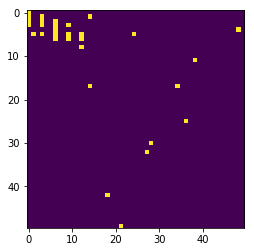

In [431]:
plt.imshow(est_beta_duncan_01_binary[0,:].reshape(50,50))

# Plot ROC curve with confidence band

In [16]:
def plot_roc(fpr, tpr, roc_auc, color,linestyle, method_name):
    mean_auc = np.mean(roc_auc)
    std_auc = np.std(roc_auc)
    mean_tpr = np.mean(tpr,axis=0)
    std_tpr = np.std(tpr,axis=0)
    plt.plot(fpr, mean_tpr, color=color,linestyle=linestyle,
             label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (method_name, mean_auc, std_auc),
             lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=.8)
    
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(fpr, tprs_lower, tprs_upper, color=color, alpha=.2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Average False Positive Rate')
    plt.ylabel('Average True Positive Rate')
    plt.legend(loc="lower right")

# Results controlled FDR = 0.1

0
1
2


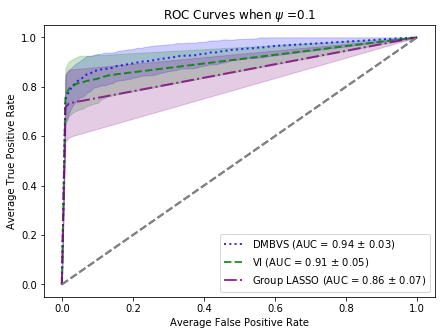

In [220]:
plt.figure(figsize=(7,5)) 

tpr_model = [tprs_duncan,tprs_vi,tprs_cl]
roc_auc_model = [aucs_duncan,aucs_vi,aucs_cl]
color=['b','g','purple']
linestyle= [':' , 'dashed','-.']
method_name = ['DMBVS', 'VI', 'Group LASSO' ]
for i in range(3):
    print(i)
    plot_roc(mean_fpr, tpr_model[i], roc_auc_model[i], color=color[i], linestyle=linestyle[i], method_name=method_name[i])
plt.title(r'ROC Curves when $\psi$ ={}'.format(0.1))


0
1
2


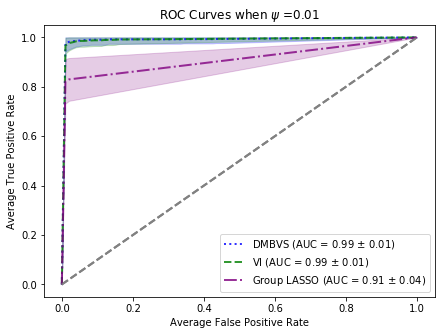

In [212]:
plt.figure(figsize=(7,5)) 
tpr_model = [tprs_duncan,tprs_vi,tprs_cl]
roc_auc_model = [aucs_duncan,aucs_vi,aucs_cl]
color=['b','g','purple']
linestyle= [':' , 'dashed','-.']
method_name = ['DMBVS', 'VI', 'Group LASSO' ]
for i in range(3):
    print(i)
    plot_roc(mean_fpr, tpr_model[i], roc_auc_model[i], color=color[i], linestyle=linestyle[i], method_name=method_name[i])
plt.title(r'ROC Curves when $\psi$ ={}'.format(0.01))


# Non-local Density Plots

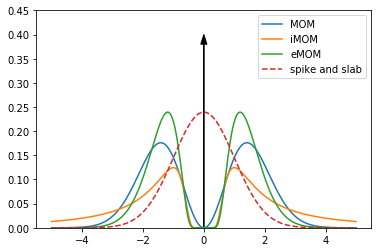

In [412]:
from scipy.stats import norm

def MOM(x, tau):
    return x**2/tau**(1.5) * (1/np.sqrt(2*np.pi) * np.exp(-x**2/(2*tau)))

def iMOM(x, tau):
    return (1/np.sqrt(np.pi)/ x**2) *np.sqrt(tau) * np.exp(-(1/(x**2))*tau)

def peMOM(x, tau):
    return np.exp(np.sqrt(2)-tau/x**2) * (1/np.sqrt(2*np.pi) * np.exp(-x**2/2))
fig, ax = plt.subplots()
non_zero_weight = 0.6
ax.arrow(0,0,0,1-non_zero_weight-0.02,  head_width=0.2, head_length=0.02, fc='k', ec='k')

label=['MOM', 'iMOM', 'eMOM','spike and slab']

plt.plot(np.linspace(-5,5,1000),[non_zero_weight*MOM(x,1) for x in np.linspace(-5,5,1000)], label=label[0])
plt.plot(np.linspace(-5,5,1000),[non_zero_weight*iMOM(x,1) for x in np.linspace(-5,5,1000)], label=label[1])
plt.plot(np.linspace(-5,5,1000),[non_zero_weight*peMOM(x,1) for x in np.linspace(-5,5,1000)], label=label[2])
plt.plot(np.linspace(-5,5,1000),[non_zero_weight*norm.pdf(x,0,1) for x in np.linspace(-5,5,1000)], label=label[3],linestyle='dashed')

plt.ylim(0,0.45)
plt.legend()
# plt.savefig('allprior.png')

# Concrete Density Plots

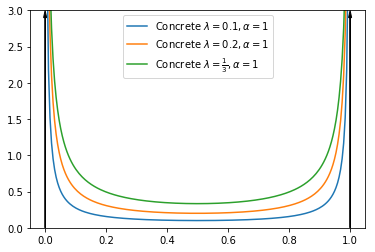

In [485]:
def concrete(x, alpha, lbd):
        
    return lbd*alpha*x**(-lbd-1)*(1-x)**(-lbd-1)/(alpha*x**(-lbd)+(1-x)**(-lbd))**2
fig, ax = plt.subplots()
ax.arrow(0,0,0,2.9,  head_width=0.01, head_length=0.1, fc='k', ec='k')
ax.arrow(1,0,0,2.9,  head_width=0.01, head_length=0.1, fc='k', ec='k')

label = [r'Concrete $\lambda=0.1, \alpha=1$',r'Concrete $\lambda=0.2, \alpha=1$', r'Concrete $\lambda=\frac{1}{3}, \alpha=1$',
        r'stretch and fold concrete $\zeta=1.1,\gamma=-0.1$']
plt.plot(np.linspace(0.001,1-0.001,200),[concrete(x,1,lbd=1/10) for x in np.linspace(0.001,1-0.001,200)], label=label[0])
plt.plot(np.linspace(0.001,1-0.001,200),[concrete(x,1,lbd=1/5) for x in np.linspace(0.001,1-0.001,200)], label=label[1])
plt.plot(np.linspace(0.001,1-0.001,200),[concrete(x,1,lbd=1/3) for x in np.linspace(0.001,1-0.001,200)], label=label[2])

plt.ylim(0,3)
plt.legend()


# Stretch and Fold Concrete Density Plot

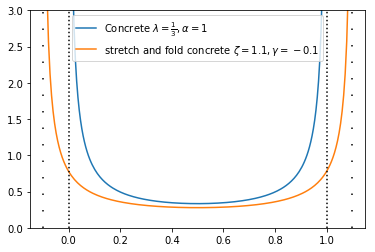

In [515]:
lw = -0.09
up = 1.09
plt.plot(np.linspace(0.001,1-0.001,200),[concrete(x,1,lbd=1/3) for x in np.linspace(0.001,1-0.001,200)], label=label[2])
plt.plot(np.linspace(lw, up, 200),[concrete((x+0.1)/1.2,1,lbd=1/3)/1.2 for x in np.linspace(lw,up,200)], label=label[3])
plt.axvline(x=-0, linestyle='dotted',color='black')
plt.axvline(x=1, linestyle='dotted',color='black')

plt.axvline(x=-0.1, linestyle=(0, (1, 10)),color='black')
plt.axvline(x=1.1, linestyle=(0, (1, 10)),color='black')
# plt.fill_between(np.linspace(-0.1,-0.001,50),0, [concrete((x+0.1)/1.2,1,lbd=1/3)/1.2 for x in np.linspace(-0.-0.001,0,50)]\
#                 ,  facecolor='green', alpha=0.5)

plt.ylim(0,3)
plt.legend()